# Haematopoiesis dataset

The original data in this example is from the following article:

Valérie Marot-Lassauzaie, Brigitte Joanne Bouman, et al. Towards reliable quantification of cell state velocities bioRxiv (2022)

See Github repo https://github.com/HaghverdiLab/velocity_notebooks

For details of the preprocessing (namely, how `P_kappavelo.npy` was obtained), see https://github.com/zsteve/locaTE-paper/tree/main/examples/HSPC

In [2]:
import anndata as ad
import scvelo as scv
import pandas as pd
import os
import numpy as np
import scanpy as sc
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
DATA_DIR = "data/"

Load data, filter and preprocess

In [20]:
adata = ad.read_h5ad(os.path.join(DATA_DIR, "anndata_raw.h5ad"))
adata.obs["pseudotime"] = np.load(os.path.join(DATA_DIR, "pseudotime.npy"))
adata.uns["celltypes_colors"] = pd.read_csv(os.path.join(DATA_DIR, "celltypes_colors.csv"), header=None).iloc[:,0].values
adata.obsm["X_umap"] = pd.read_csv(os.path.join(DATA_DIR, "UMAP_coordinates.csv"), header = 0, index_col = 0).values
adata.obsm["X_umap_original"] = pd.read_csv(os.path.join(DATA_DIR, "original_UMAP.csv"), header = None).values
scv.pp.filter_and_normalize(adata, min_shared_counts = 20, n_top_genes = 2000)

Filtered out 18125 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


In [21]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)

Fetch TF list from AnimalTFDB3 

In [22]:
!wget http://bioinfo.life.hust.edu.cn/static/AnimalTFDB3/download/Mus_musculus_TF -P data/

--2023-09-16 13:13:15--  http://bioinfo.life.hust.edu.cn/static/AnimalTFDB3/download/Mus_musculus_TF
Resolving bioinfo.life.hust.edu.cn (bioinfo.life.hust.edu.cn)... 222.20.95.101
Connecting to bioinfo.life.hust.edu.cn (bioinfo.life.hust.edu.cn)|222.20.95.101|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159032 (155K)
Saving to: ‘data/Mus_musculus_TF.7’

Mus_musculus_TF.7   100%[===================>] 155.30K   302KB/s    in 0.5s    

2023-09-16 13:13:16 (302 KB/s) - ‘data/Mus_musculus_TF.7’ saved [159032/159032]



In [23]:
df = pd.read_csv(os.path.join(DATA_DIR, "Mus_musculus_TF"), sep = "\t")
adata.var['istf'] = np.isin(adata.var.index.str.lower(), df.Symbol.str.lower())

In [25]:
# construct cell-cell distances from kNN graph
import sklearn as sk
import scipy as sp
nb = sk.neighbors.NearestNeighbors(n_neighbors=30).fit(adata.obsm["X_pca"])
G_sp = nb.kneighbors_graph(mode = "distance")
# G_sp = adata.uns['neighbors']['distances']
adata.obsm["C"] = sp.sparse.csgraph.floyd_warshall(G_sp, directed = False)**2
# calculate neighbourhood kernel using QOT
import ot
adata.obsm["R"] = ot.smooth.smooth_ot_dual(np.ones(adata.shape[0]), np.ones(adata.shape[0]), adata.obsm["C"], 2.5*adata.obsm["C"].mean())

2023-09-16 13:13:54.076162: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


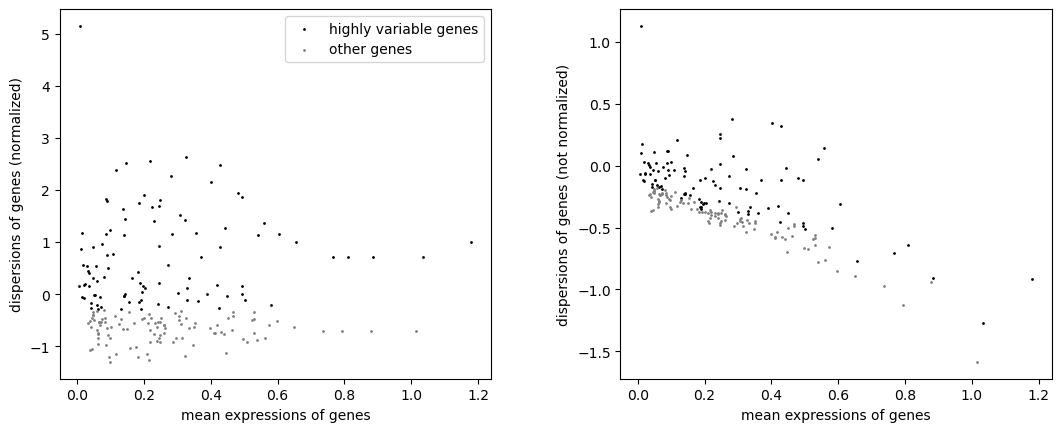

In [26]:
adata_subset = adata.copy()
sc.pp.log1p(adata_subset)
adata_subset = adata_subset[:, adata_subset.var.istf]
# subset out 100 variable TFs
N_hvg = 100
sc.pp.highly_variable_genes(adata_subset, n_top_genes = N_hvg, subset = False)
sc.pl.highly_variable_genes(adata_subset)
sc.pp.highly_variable_genes(adata_subset, n_top_genes = N_hvg, subset = True)

In [27]:
np.save(os.path.join(DATA_DIR, "X.npy"), adata_subset.X[:, adata_subset.var.istf].todense())
np.save(os.path.join(DATA_DIR, "X_pca.npy"), adata_subset.obsm["X_pca"])
np.save(os.path.join(DATA_DIR, "X_umap.npy"), adata_subset.obsm["X_umap"])
np.save(os.path.join(DATA_DIR, "R.npy"), adata.obsm["R"])

In [3]:
!julia ../../src/locaTE_cmd.jl --lambda1 10.0 --lambda2 0.001 --k_lap 25 --gpu --outdir locaTE_output $DATA_DIR/X.npy $DATA_DIR/X_pca.npy $DATA_DIR/P_kappavelo.npy $DATA_DIR/R.npy

[ Info: Reading input...
[ Info: Estimating TE scores...
Progress: 100%|█████████████████████████████████████████| Time: 0:05:23K
[ Info: Denoising...
Progress: 100%|█████████████████████████████████████████| Time: 0:05:20
[ Info: ΔX = 4.483079522717422e-9, ΔZ = 7.01304405468367e-7, ΔW = 1.0424084807836298e-6
[ Info: tr(X'LX) = 6.093927438935762, 0.5|X-G|^2 = 7.450156044390068, |X|1 = 24561.315408456772
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05

SYSTEM: caught exception of type :IOError while trying to print a failed Task notice; giving up


In [ ]:
adata_subset.write_h5ad(os.path.join(DATA_DIR, "adata_subset_tf.h5ad"))